In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import torch
from pathlib import Path
from typing import List, Tuple
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [3]:
def load_segments_from_files(
    infant_file_path: Path,
    adult_file_path: Path,
    min_length: int = 125,
) -> List[pd.DataFrame]:
    meaningfull_columns = ["Frame", "success", "AU06_r", "AU12_r"]
    adult_file = pd.read_csv(adult_file_path)[meaningfull_columns]
    infant_file = pd.read_csv(infant_file_path)[meaningfull_columns]

    merged_file = pd.merge(
        infant_file,
        adult_file,
        on="Frame",
        how="inner",
        suffixes=("_infant", "_adult"),
    )

    continous_dfs: List[pd.DataFrame] = []
    output_columns = [
        "Frame",
        "AU06_r_infant",
        "AU12_r_infant",
        "AU06_r_adult",
        "AU12_r_adult",
    ]
    current_segment = pd.DataFrame(columns=output_columns)
    for row in merged_file.itertuples():
        if row.success_infant >= 0.75 and row.success_adult >= 0.75:
            current_segment.loc[len(current_segment)] = (
                row.Frame,
                row.AU06_r_infant,
                row.AU12_r_infant,
                row.AU06_r_adult,
                row.AU12_r_adult,
            )
        else:
            if len(current_segment) > min_length:
                continous_dfs.append(current_segment)
            current_segment = pd.DataFrame(columns=output_columns)
    if len(current_segment) > min_length:
        continous_dfs.append(current_segment)
    return continous_dfs

In [4]:
def segments_from_one_video_to_dataset(
    segments: List[pd.DataFrame],
    seq_length: int,
    train_test_split: float = 0.8,
    step = 10,
) -> Tuple[torch.Tensor, torch.Tensor]:
    X = []
    for segment in segments:
        data = segment[
            ["AU06_r_infant", "AU12_r_infant", "AU06_r_adult", "AU12_r_adult"]
        ].to_numpy()
        num_samples = len(data) - seq_length + 1
        for i in range(0, num_samples, step):
            X.append(data[i : i + seq_length])
            
    numpy_X = np.array(X, dtype=np.float32)
    split_idx = int(len(X) * train_test_split)
    train_X = torch.from_numpy(numpy_X[:split_idx])
    test_X = torch.from_numpy(numpy_X[split_idx:])
    return train_X, test_X

In [5]:
def load_multiple_files(
    month: int,
    root: Path,
    seq_length: int,
) -> Tuple[torch.Tensor, torch.Tensor]:
    subdirs = [p for p in root.iterdir() if p.is_dir()]
    train_X_list: List[torch.Tensor] = []
    test_X_list: List[torch.Tensor] = []
    for subdir in subdirs:
        if subdir.match(f"**/diti_*_{month}"):
            infant_path = subdir / "Kamera 1" / "infant.csv"
            adult_path = subdir / "Kamera 2" / "adult.csv"
            if not infant_path.exists() or not adult_path.exists():
                continue
            segments = load_segments_from_files(infant_path, adult_path)
            if not segments:
                continue
            tX, eX = segments_from_one_video_to_dataset(
                segments, seq_length=seq_length
            )
            if len(tX) == 0:
                continue
            train_X_list.append(tX)
            test_X_list.append(eX)

    if not train_X_list:
        raise ValueError("No training data found for the specified month")
    train_X = torch.cat(train_X_list, dim=0)
    test_X = torch.cat(test_X_list, dim=0)
    return train_X, test_X


In [6]:
Train_X, Test_X = load_multiple_files(
    month=1,
    root=Path("/shared/results/common/z1211445/korelacje-transformer/cut_short_fixed_results_openface2_22_01"),
    seq_length=500,
)


In [7]:
Train_X.shape

torch.Size([3202, 500, 4])

In [8]:
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(Train_X)
test_dataset = TensorDataset(Test_X)
torch.save(train_dataset, "train_dataset_500.pt")
torch.save(test_dataset, "test_dataset_500.pt")

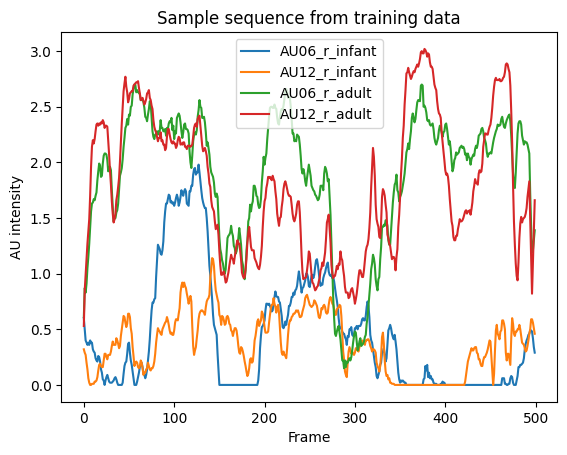

In [9]:
import matplotlib.pyplot as plt
plt.plot(Train_X[0, :, 0].numpy(), label="AU06_r_infant")
plt.plot(Train_X[0, :, 1].numpy(), label="AU12_r_infant")
plt.plot(Train_X[0, :, 2].numpy(), label="AU06_r_adult")
plt.plot(Train_X[0, :, 3].numpy(), label="AU12_r_adult")
plt.legend()
plt.title("Sample sequence from training data")
plt.xlabel("Frame")
plt.ylabel("AU intensity")
plt.show()

In [10]:
import math
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

In [11]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

## Masked Transformer training (self-reconstruction)

Goal: predict the same multivariate time series while randomly masking each full series/channel with probability `0.333`.

Input shape is expected as `[idx, frame, serie_idx]` (batch, time, channels).

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.pe[:, : x.size(1)]


class MaskedSeriesTransformer(nn.Module):
    def __init__(
        self,
        input_dim: int,
        d_model: int = 128,
        nhead: int = 8,
        num_layers: int = 4,
        ff_dim: int = 256,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(d_model, input_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.input_proj(x)
        h = self.pos_enc(h)
        h = self.encoder(h)
        return self.output_proj(h)




In [13]:
def apply_series_mask(x: torch.Tensor, mask_prob: float = 0.333):
    # x: [batch, frame, serie_idx]
    bsz, _, n_series = x.shape
    keep = (torch.rand(bsz, 1, n_series, device=x.device) > mask_prob).float()

    # Ensure at least one series is masked per sample
    all_kept = (keep.sum(dim=2, keepdim=True) == n_series)
    if all_kept.any():
        force_idx = torch.randint(0, n_series, (all_kept.sum().item(),), device=x.device)
        sample_ids = torch.where(all_kept.squeeze(-1).squeeze(-1))[0]
        keep[sample_ids, 0, force_idx] = 0.0

    x_masked = x * keep
    masked_positions = (keep == 0).expand(-1, x.size(1), -1)
    return x_masked, masked_positions


def masked_mse_loss(pred: torch.Tensor, target: torch.Tensor, masked_positions: torch.Tensor):
    diff2 = (pred - target).pow(2)
    masked_diff2 = diff2[masked_positions]
    if masked_diff2.numel() == 0:
        return diff2.mean()
    return masked_diff2.mean()

In [18]:
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


batch_size = 32
mask_prob = 0.333
num_epochs = 200
learning_rate = 1e-3
early_stopping_patience = 10
min_delta = 1e-5

train_loader = DataLoader(TensorDataset(Train_X), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(Test_X), batch_size=batch_size, shuffle=False)

input_dim = Train_X.shape[-1]
model = MaskedSeriesTransformer(
    input_dim=input_dim,
    d_model=128,
    nhead=8,
    num_layers=4,
    ff_dim=256,
    dropout=0.1,
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

Device: cuda


Epoch 01/200 | train=0.298477 | test=0.179326
Epoch 02/200 | train=0.248364 | test=0.264369
Epoch 03/200 | train=0.233128 | test=0.168760
Epoch 04/200 | train=0.216413 | test=0.190801
Epoch 05/200 | train=0.209526 | test=0.174339
Epoch 06/200 | train=0.215902 | test=0.170149
Epoch 07/200 | train=0.204155 | test=0.164110
Epoch 08/200 | train=0.212296 | test=0.181789
Epoch 09/200 | train=0.203308 | test=0.189958
Epoch 10/200 | train=0.196378 | test=0.192793
Epoch 11/200 | train=0.190037 | test=0.169885
Epoch 12/200 | train=0.196223 | test=0.167243
Epoch 13/200 | train=0.182665 | test=0.165510
Epoch 14/200 | train=0.182390 | test=0.174368
Epoch 15/200 | train=0.181028 | test=0.177897
Epoch 16/200 | train=0.170449 | test=0.182747
Epoch 17/200 | train=0.182696 | test=0.189851
Early stopping at epoch 17 (best epoch: 7, best test loss: 0.164110)


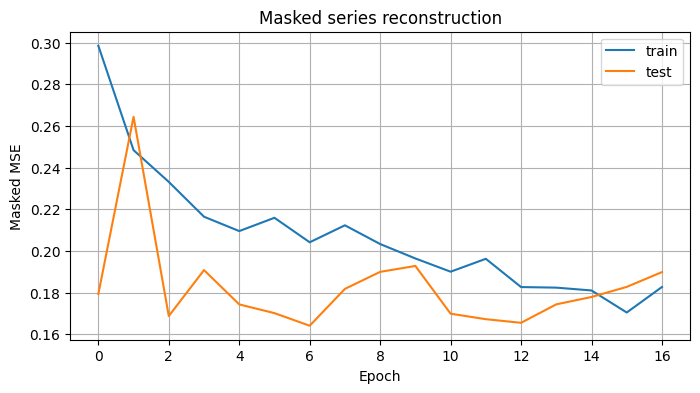

Saved: masked_series_transformer.pt (best epoch: 7, best test loss: 0.164110)


In [19]:
train_losses = []
test_losses = []

best_test_loss = float("inf")
best_epoch = 0
best_model_state = None
epochs_without_improvement = 0

for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_train_loss = 0.0
    for (x,) in train_loader:
        x = x.to(device)
        x_masked, masked_positions = apply_series_mask(x, mask_prob=mask_prob)
        pred = model(x_masked)
        loss = masked_mse_loss(pred, x, masked_positions)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_train_loss += loss.item() * x.size(0)

    epoch_train_loss /= len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    epoch_test_loss = 0.0
    with torch.no_grad():
        for (x,) in test_loader:
            x = x.to(device)
            x_masked, masked_positions = apply_series_mask(x, mask_prob=mask_prob)
            pred = model(x_masked)
            loss = masked_mse_loss(pred, x, masked_positions)
            epoch_test_loss += loss.item() * x.size(0)

    epoch_test_loss /= len(test_loader.dataset)
    test_losses.append(epoch_test_loss)

    print(f"Epoch {epoch:02d}/{num_epochs} | train={epoch_train_loss:.6f} | test={epoch_test_loss:.6f}")

    if epoch_test_loss < (best_test_loss - min_delta):
        best_test_loss = epoch_test_loss
        best_epoch = epoch
        best_model_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print(
                f"Early stopping at epoch {epoch} (best epoch: {best_epoch}, best test loss: {best_test_loss:.6f})"
            )
            break

if best_model_state is not None:
    model.load_state_dict(best_model_state)

plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.xlabel("Epoch")
plt.ylabel("Masked MSE")
plt.title("Masked series reconstruction")
plt.legend()
plt.grid(True)
plt.show()


torch.save(
    {
        "model_state_dict": model.state_dict(),
        "input_dim": input_dim,
        "mask_prob": mask_prob,
        "num_epochs": num_epochs,
        "best_epoch": best_epoch,
        "best_test_loss": best_test_loss,
        "early_stopping_patience": early_stopping_patience,
        "min_delta": min_delta,
        "train_losses": train_losses,
        "test_losses": test_losses,
    },
    "masked_series_transformer.pt",
)

print(
    f"Saved: masked_series_transformer.pt (best epoch: {best_epoch}, best test loss: {best_test_loss:.6f})"
)

In [ ]:
model.eval()

sample_idx = 0
x_true = Test_X[sample_idx : sample_idx + 1].to(device)  # [1, time, channels]
x_masked, masked_positions = apply_series_mask(x_true, mask_prob=mask_prob)

with torch.no_grad():
    x_pred = model(x_masked)

x_true_np = x_true.squeeze(0).detach().cpu().numpy()
x_masked_np = x_masked.squeeze(0).detach().cpu().numpy()
x_pred_np = x_pred.squeeze(0).detach().cpu().numpy()
masked_np = masked_positions.squeeze(0).detach().cpu().numpy()

channel_names = ["AU06_r_infant", "AU12_r_infant", "AU06_r_adult", "AU12_r_adult"]
n_channels = x_true_np.shape[1]

fig, axes = plt.subplots(n_channels, 1, figsize=(12, 2.8 * n_channels), sharex=True)
if n_channels == 1:
    axes = [axes]

for ch in range(n_channels):
    ax = axes[ch]
    ax.plot(x_true_np[:, ch], label="target", linewidth=1.8)
    ax.plot(x_masked_np[:, ch], label="masked input", linestyle="--", alpha=0.8)
    ax.plot(x_pred_np[:, ch], label="prediction", linewidth=1.2)

    ch_name = channel_names[ch] if ch < len(channel_names) else f"channel_{ch}"
    is_masked_channel = bool(masked_np[:, ch].any())
    ax.set_title(f"{ch_name} | masked={is_masked_channel}")
    ax.set_ylabel("AU")
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Frame")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
plt.tight_layout()
plt.show()